# Analysis of a Synthetic Sample

In this tutorial we analyze the magnetic signal of a set of grains in a synthetic sample, using SQUID magnetometry data and tomographic data. We start by importing the corresponding modules for the inversion:

In [1]:
from mmt_dipole_inverse_config import set_max_num_threads
set_max_num_threads(4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mmt_dipole_inverse as dpinv
import mmt_dipole_inverse.tools as dpinv_tools

In [3]:
import requests, zipfile, io
from pathlib import Path

We will download the dataset of the study of a synthetic sample [1] from the repository in [2]. The latest version of the dataset includes 3 formatted areas of the scanned surface and the cuboid representation of the grain to perform a numerical inversion. The grain geometry and location are obtained from tomographic data and the raw data format are pixels. To speed up the inversions the pixel data is converted to aggregation of largest possible cuboids that represents the geometry of the grain. In the dataset this step is already done, but it is worth mentioning that the `mmt_dipole_inverse` module contains a cuboid decomposition method in the `tools` module.

<sub>[1] de Groot, L. V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H. Determining Individual Particle Magnetizations in Assemblages of Micrograins. Geophysical Research Letters, 45 (7), 2995-3000. 2017GL076634. (2018). https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/ DOI: 10.1002/2017GL076634<sub>

<sub>[2] de Groot, L. V, Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H. (2018): List of grains and results of the Scanning SQUID Magnetometer (SSM) scan. PANGAEA, https://doi.org/10.1594/PANGAEA.886724 </sub>

In [4]:
# Download the data to this directory:
data_dir = Path('deGroot2018_data')
data_dir.mkdir(exist_ok=True)

In [5]:
if not any(data_dir.iterdir()):
    data_url = 'https://store.pangaea.de/Publications/deGroot-etal_2018/Micro-grain-data.zip'
    r = requests.get(data_url)
    # Pass the request output `r` (in byte-like format) to get a binary stream
    # from a data piece in memory (buffer) using BytesIO -> like a file in mem
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(data_dir)

In [6]:
# Now open the ZIP file with formatted data:
z = zipfile.ZipFile(data_dir / 'V2_2021-04.zip')
z.extractall(data_dir)

## Area 1: Unknown Magnetic State

Here we define the parameters for the scan surface and the files containing the surface scanning data and the information on the cuboid representation of the grains:

In [7]:
data_dir = Path('deGroot2018_data/PDI-16803')

# location and name of QDM and cuboid file
ScanFile = data_dir / 'Area1-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A1.txt'

# 
SQUID_domain = np.array([[0, 0], [350, 200]]) * 1e-6
SQUID_spacing = 1e-6
SQUID_deltax = 0.5e-6
SQUID_deltay = 0.5e-6
SQUID_area = 1e-12
scan_height = 2e-6

Input the scan surface parameters into the `Dipole` class:

In [8]:
mag_inv = dpinv.dipole_inverse.Dipole(SQUID_domain, SQUID_spacing,
        SQUID_deltax, SQUID_deltay, SQUID_area, scan_height)

In [9]:
mag_inv.read_files(ScanFile, CuboidFile, cuboid_scaling_factor=1e-6)

We then compute the forward (Green's) matrix that we use to invert the scan field:

In [10]:
mag_inv.prepare_matrix(method='cython')

And we do the inversion:

In [11]:
mag_inv.calculate_inverse(method='scipy_pinv2', atol=1e-25)

Start inversion with 70551 knowns and 24 unknowns
Inversion has been carried out


The inverted magnetization values are:

In [12]:
mag_inv.Mag.reshape(-1, 3)

array([[  3073.47734619,    794.21817383,  -1394.1549433 ],
       [  -721.16937777,  -2167.196952  ,  -3132.0975484 ],
       [-12596.94411688,  -3373.80667257,  -7675.33653381],
       [  2116.48065982,  -1054.15876876,   2898.11481584],
       [  4722.76611475,   9681.78229873,  25577.32991099],
       [  1958.37830143,  -2082.26607045,  -1089.23295   ],
       [ 54738.76630559,  -9395.10575441,  74010.37408788],
       [ -4592.66677362,  -1717.13853656,   5583.08683155]])

We can also print the magnetization magnitudes and compare them to the ones obtained in the original paper:

In [13]:
dG_Area1UMS = np.array([3544.3, 3923.7, 15346.8, 3770.7, 28147.8, 2845.9, 92191.2, 7154.4])

In [14]:
MagNorms = np.linalg.norm(mag_inv.Mag.reshape(-1, 3), axis=1)
for m, mag in enumerate(MagNorms):
    print(f'Grain {m + 1}  |M| = {mag:>9.3f} A/m    |M|_dG = {dG_Area1UMS[m]:>9.3f} A/m')

Grain 1  |M| =  3467.090 A/m    |M|_dG =  3544.300 A/m
Grain 2  |M| =  3876.450 A/m    |M|_dG =  3923.700 A/m
Grain 3  |M| = 15131.965 A/m    |M|_dG = 15346.800 A/m
Grain 4  |M| =  3740.296 A/m    |M|_dG =  3770.700 A/m
Grain 5  |M| = 27753.220 A/m    |M|_dG = 28147.800 A/m
Grain 6  |M| =  3059.004 A/m    |M|_dG =  2845.900 A/m
Grain 7  |M| = 92531.811 A/m    |M|_dG = 92191.200 A/m
Grain 8  |M| =  7430.479 A/m    |M|_dG =  7154.400 A/m


### Plotting the results

Define first the geometries into our `mag_inv` class instance. All the spatial locations of the plots will be scaled by a factor of 1µm:

In [15]:
dpinv_tools.plot.set_grain_geometries(mag_inv, spatial_scaling=1e6)

We can now plot the grain profiles and forward/inversion fields. Note that we scale the fields by the `scan_area` to have the flux in Tesla rather than Tesla.m^2:

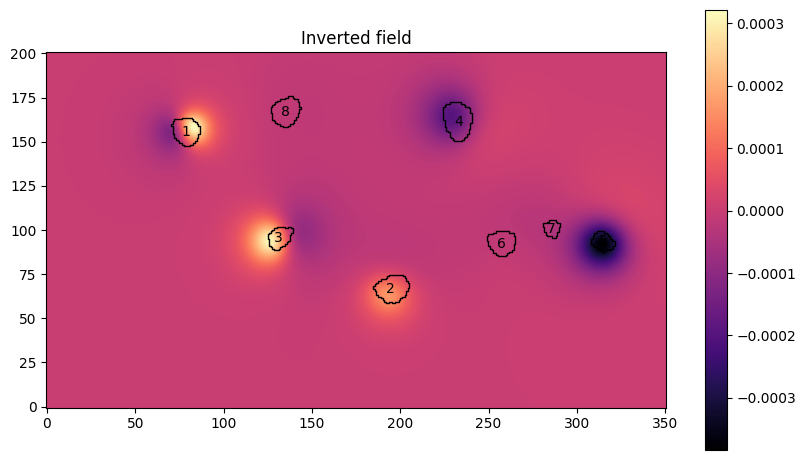

In [16]:
f, ax = plt.subplots(figsize=(10, 10 * 200 / 350))
dpinv_tools.plot.plot_grain_boundaries(mag_inv, ax)
im = dpinv_tools.plot.plot_inversion_field(mag_inv, ax, 
                                           scale_field=1/mag_inv.scan_area)
plt.colorbar(im)
ax.set_title('Inverted field')
plt.show()

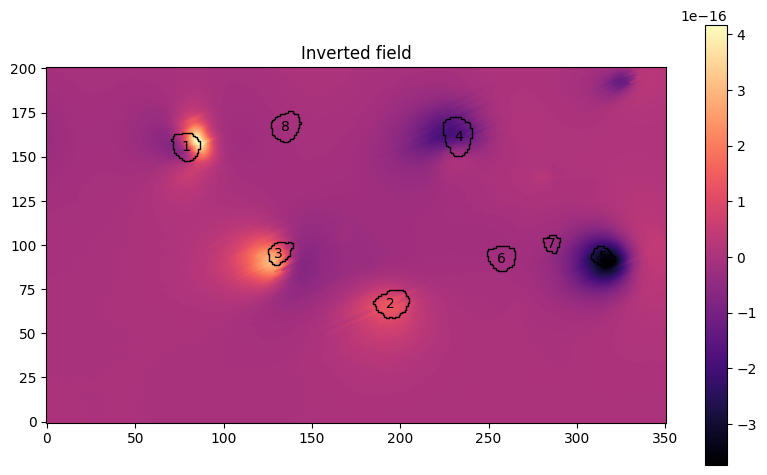

In [17]:
f, ax = plt.subplots(figsize=(10, 10 * 200 / 350))
dpinv_tools.plot.plot_grain_boundaries(mag_inv, ax)
im = dpinv_tools.plot.plot_scan_field(mag_inv, ax)
plt.colorbar(im)
ax.set_title('Inverted field')
plt.show()

### 3D visualization of grains

Finally, we can visualize the profile of the grains using a 3D plot. Since Matplotlib is a 2D graphics tool a good visualization  requires a tunning the visualization angles and lights. We start extracting the positions, size and indexes of the cuboids. Notice that here we invert the z-axis:

In [18]:
cuboid_data = np.copy(mag_inv.cuboids)
cuboid_data[:, 2] *= -1
cx, cy, cz, cdx, cdy, cdz = (cuboid_data[:, i] for i in range(6))
cuboid_indexes = cuboid_data[:, 6].astype(np.int16)

In [19]:
from matplotlib.colors import LightSource

Here we define a 3D system of axes and we use the `mmt_dipole_inverse.tools.plot.plotCubeAt` function to obtain a 3D collection that can be added to our axes system. We then redefine the plot limits, view angles and aspect ratio:

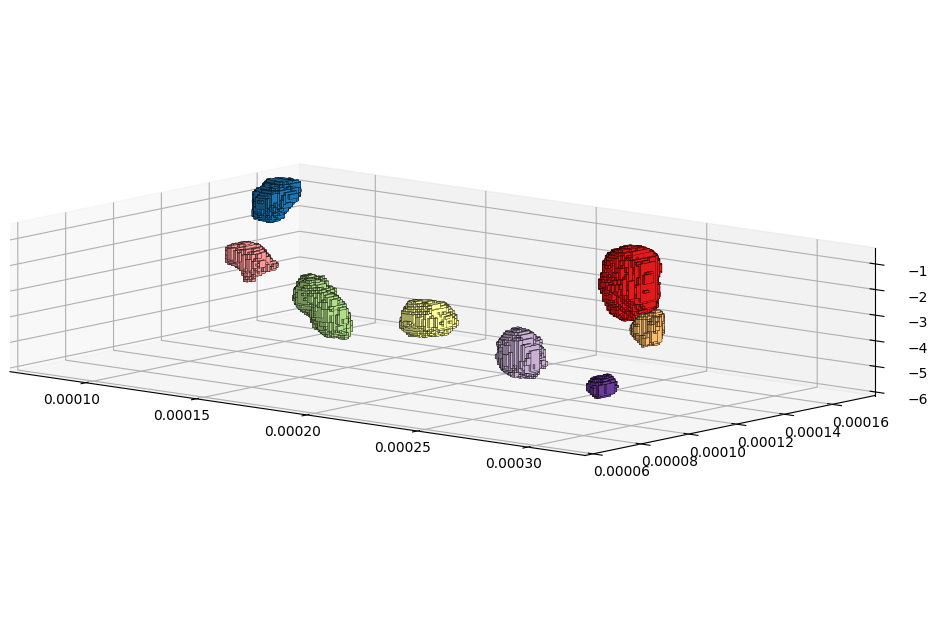

In [20]:
fig = plt.figure(figsize=(10, 8), constrained_layout=False)
# Define 3D axes
ax = plt.axes(projection='3d', proj_type='ortho')
# Use a discrete colormap to color grains according to their indices
cmap = plt.get_cmap('Paired', 10)
# Define a light source although is not strictly necessary
ls = LightSource(azdeg=90, altdeg=10)
# Here we obtain the Matplotlib collection to be plotted in our 3D system
col = dpinv_tools.plot.plotCubeAt(cuboid_data[:, :3],
                                  2 * cuboid_data[:, 3:6],
                                  edgecolor="k", linewidth=.2,
                                  colors=cmap(cuboid_indexes),
                                  # lightsource=True
                                  lightsource=ls
                                  )
# We finally add it to the plot as a collection
ax.add_collection3d(col)

# ax.scatter([ctr_x], [ctr_y], [ctr_z])
ax.set_xlim([cx.min(), cx.max()])
ax.set_ylim([cy.min(), cy.max()])
ax.set_zlim([cz.min(), cz.max()])

ax.set_box_aspect((1, 0.6, 0.2), zoom=1.4)
ax.view_init(10, -50)
plt.show()